In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd

dataset_folders = ["Celeb-real", "Youtube-real", "Celeb-Youtube-fake", "test"]
output_directory = "preprocessed_data"
os.makedirs(output_directory, exist_ok=True)

def preprocess_videos(dataset_folder, label, output_directory):
    for video_file in os.listdir(dataset_folder):
        video_path = os.path.join(dataset_folder, video_file)
        
        # Create output directory for the current video
        video_output_directory = os.path.join(output_directory, f"{label}_{video_file.split('.')[0]}")
        os.makedirs(video_output_directory, exist_ok=True)
        
        # Open video file
        cap = cv2.VideoCapture(video_path)
        success, image = cap.read()
        count = 0
        
        # Loop through frames and save them as images
        while success:
            # Define output file path for the current frame
            frame_path = os.path.join(video_output_directory, f"frame_{count}.jpg")
            
            # Resize frame to desired dimensions (e.g., 224x224) and save as JPEG
            resized_image = cv2.resize(image, (224, 224))
            cv2.imwrite(frame_path, resized_image)
            
            success, image = cap.read()
            count += 1
        
        cap.release()

for i, folder in enumerate(dataset_folders):
    if i < 2:
        label = "real"
    elif i == 2:
        label = "fake"
    else:
        label = "test"
    
    dataset_folder_path = os.path.join(".", folder)
    preprocess_videos(dataset_folder_path, label, output_directory)

preprocessed_data_path = "preprocessed_data"
real_folders = [folder for folder in os.listdir(preprocessed_data_path) if folder.startswith('real')]
fake_folders = [folder for folder in os.listdir(preprocessed_data_path) if folder.startswith('fake')]
test_folders = [folder for folder in os.listdir(preprocessed_data_path) if folder.startswith('test')]


# Define function to load data batch by batch using a generator
def data_generator(data_folders, batch_size=32):
    while True:
        X = []
        y = []
        for folder in data_folders:
            folder_path = os.path.join(preprocessed_data_path, folder)
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)
                # Read image using OpenCV
                image = cv2.imread(image_path)
                # Resize image to target size
                image = cv2.resize(image, (224, 224))
                # Normalize pixel values to range [0, 1]
                image = image.astype('float32') / 255.0
                X.append(image)
                # Append label to y
                y.append(int(folder.startswith('real')))
                # Yield batch if it reaches batch size
                if len(X) == batch_size:
                    yield np.array(X), np.array(y)
                    X = []
                    y = []

# Split data folders into training, validation, and test sets

train_real_folders, val_real_folders = train_test_split(real_folders, test_size=0.2, random_state=42)
train_fake_folders, val_fake_folders = train_test_split(fake_folders, test_size=0.2, random_state=42)

# Create data generators for training, validation, and test sets
train_generator = data_generator(train_real_folders + train_fake_folders)
val_generator = data_generator(val_real_folders + val_fake_folders)
test_generator = data_generator(test_folders)

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using generators
# Train the model using generators with reduced batch size
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_real_folders + train_fake_folders),
                    epochs=10, 
                    batch_size=8,  # Reduce batch size to 8
                    validation_data=val_generator, 
                    validation_steps=len(val_real_folders + val_fake_folders))


# Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_data_folders))
# print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# # Predict classes on the test set
# y_pred = model.predict(test_generator, steps=len(test_data_folders)) > 0.5  # Thresholding at 0.5 for binary classification

# # Flatten the predictions and true labels
# y_pred_flat = y_pred.flatten()
# y_true_flat = np.array([int(folder.startswith('real')) for folder in test_data_folders])

# # Calculate F1 score
# f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
# precision = precision_score(y_true_flat, y_pred_flat, average='binary')
# recall = recall_score(y_true_flat, y_pred_flat, average='binary')

# # Print F1 score to console
# print(f'F1 Score: {f1}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')

# # Save predictions to CSV file
# results_df = pd.DataFrame({'Filename': test_data_folders, 'True_Label': y_true_flat, 'Predicted_Label': y_pred_flat})
# results_df.to_csv('predictions.csv', index=False)

# # Plot training history
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.savefig('accuracy_plot.pdf')
# plt.show()

# # Create a PDF file with the F1 score
# with open('f1_score.pdf', 'w') as f:
#     f.write(f'F1 Score: {f1}\n')
#     f.write(f'Precision: {precision}\n')
#     f.write(f'Recall: {recall}\n')






Epoch 1/10


17/17 [==============================] - 19s 1s/step - loss: 0.0419 - accuracy: 0.9412 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 16s 939ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 16s 919ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 15s 907ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 16s 964ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 15s 882ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 15s 887ms/step - loss: 0.0000e+00 - accurac

In [3]:
import os
import pandas as pd
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the trained model
model = load_model('deepfake_detection_model.h5')

# Directory containing test data
test_data_dir = 'test'  # Assuming the "test" folder is in the same directory as the script

# Get list of video files in the test data directory
test_videos = os.listdir(test_data_dir)

# Initialize lists to store filenames and predictions
filenames = []
predictions = []

# Loop through each video file in the test data directory
for video_file in test_videos:
    # Read video file
    video_path = os.path.join(test_data_dir, video_file)
    cap = cv2.VideoCapture(video_path)
    
    # Preprocess video frames and make predictions
    frames = []
    while True:
        success, image = cap.read()
        if not success:
            break
        resized_image = cv2.resize(image, (224, 224))
        resized_image = resized_image.astype('float32') / 255.0
        frames.append(resized_image)
    
    # Make predictions on the video frames
    frames = np.array(frames)
    predictions.append(model.predict(frames).mean())  # Use mean prediction for video
    
    # Append filename to list
    filenames.append(video_file)

# Convert predictions to binary labels
predicted_labels = ['real' if pred >= 0.5 else 'fake' for pred in predictions]

# Create DataFrame
submission_df = pd.DataFrame({'Filename': filenames, 'Predicted_Label': predicted_labels})

# Save DataFrame to CSV
submission_df.to_csv('submission.csv', index=False)


11/11 [==============================] - 2s 141ms/step


In [6]:
print ("hello")


hello


In [10]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

# Define function to load test data
def load_test_data(test_folders):
    X = []
    y_true = []
    for folder in test_folders:
        folder_path = os.path.join(preprocessed_data_path, folder)
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = image.astype('float32') / 255.0
            X.append(image)
            y_true.append(int(folder.startswith('real')))
    return np.array(X), np.array(y_true)

# Load test data
X_test, y_true = load_test_data(test_folders)

# Load the trained model
model = load_model('deepfake_detection_model.h5')

# Predict classes on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=['fake', 'real'], labels=np.unique(y_pred))
print(report)
# Ensure all arrays have the same length
min_length = min(len(test_folders), len(y_true), len(y_pred.flatten()))
test_folders = test_folders[:min_length]
y_true = y_true[:min_length]
y_pred = y_pred.flatten()[:min_length]


# Save predictions to CSV file
results_df = pd.DataFrame({'Filename': test_folders, 'True_Label': y_true, 'Predicted_Label': y_pred.flatten()})
results_df.to_csv('predictions.csv', index=False)


40/40 [==============================] - 7s 160ms/step
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      1260

    accuracy                           1.00      1260
   macro avg       1.00      1.00      1.00      1260
weighted avg       1.00      1.00      1.00      1260



C:\Users\Dev Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2608: UserWarning: labels size, 1, does not match size of target_names, 2
  warnings.warn(


1/1 [==============================] - 0s 148ms/step
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


C:\Users\Dev Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dev Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dev Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

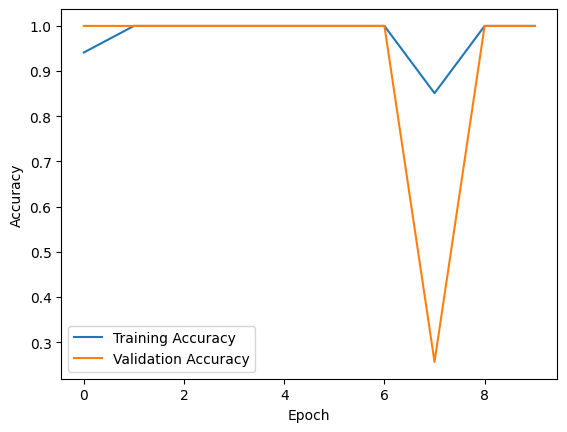

F1 score, precision, and recall saved to f1_score.pdf


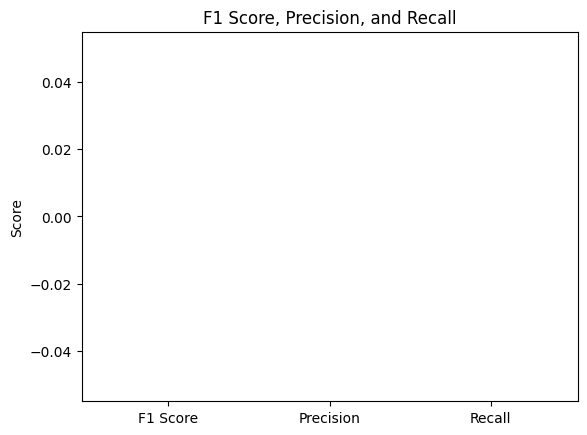

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np

# Predict classes on the test set
test_data_generator = data_generator(test_folders)
y_pred = []
iteration = 0  # Initialize iteration counter

try:
    while iteration < 50:  # Check if reached 2000 iterations
        X_batch, _ = next(test_data_generator)
        y_pred_batch = model.predict(X_batch) > 0.5  # Thresholding at 0.5 for binary classification
        y_pred.extend(y_pred_batch)
        iteration += 1  # Increment iteration counter
except StopIteration:
    pass  # Reached the end of the dataset

# Flatten the predictions and true labels
y_pred_flat = np.array(y_pred).flatten()
y_true_flat = np.array([int(folder.startswith('real')) for folder in test_folders])

# Ensure y_true_flat and y_pred_flat have the same length
min_len = min(len(y_true_flat), len(y_pred_flat))
y_true_flat = y_true_flat[:min_len]
y_pred_flat = y_pred_flat[:min_len]

# Calculate F1 score, precision, and recall
f1 = f1_score(y_true_flat, y_pred_flat, average='binary')
precision = precision_score(y_true_flat, y_pred_flat, average='binary')
recall = recall_score(y_true_flat, y_pred_flat, average='binary')

# Print F1 score, precision, and recall
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.pdf')
plt.show()

# Create a PDF file with the F1 score, precision, and recall
pdf_filename = "f1_score.pdf"
with open(pdf_filename, 'w') as f:
    f.write(f'F1 Score: {f1}\n')
    f.write(f'Precision: {precision}\n')
    f.write(f'Recall: {recall}\n')

print(f"F1 score, precision, and recall saved to {pdf_filename}")

# Plot F1 score, precision, and recall
scores = [f1, precision, recall]
labels = ['F1 Score', 'Precision', 'Recall']
plt.bar(labels, scores)
plt.ylabel('Score')
plt.title('F1 Score, Precision, and Recall')
plt.savefig("f1_score_plot.pdf")
plt.show()


In [31]:
import pandas as pd

# Convert labels to 0 or 1
y_true_binary = [0 if label == 'false' else 1 for label in y_true_flat]
y_pred_binary = [0 if label == 'false' else 1 for label in y_pred_flat]

# Create a DataFrame with true labels and predicted labels
df = pd.DataFrame({'True_Label': y_true_binary, 'Predicted_Label': y_pred_binary})

# Save the DataFrame to a CSV file
csv_filename = "labels.csv"
df.to_csv(csv_filename, index=False)

print(f"Labels saved to {csv_filename}")


Labels saved to labels.csv
